<a href="https://colab.research.google.com/github/kumphon14/Symptom_Recommendation/blob/main/Symptom_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔧 1) Setup Environment

In [ ]:
from datetime import datetime, UTC
datetime.now(UTC)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install matplotlib seaborn
!pip install scikit-learn mlxtend
!pip install fastapi uvicorn pyngrok

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Association Rules
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# API (later section)
from fastapi import FastAPI
from pyngrok import ngrok
import uvicorn

# System & Utils
import os


# ✅ 2) Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "./drive/MyDrive/Machine Learning/Symptom Recommendation System/[CONFIDENTIAL] AI symptom picker data (Agnos candidate assignment) - ai_symptom_picker.csv"
df = pd.read_csv(file_path)


Mounted at /content/drive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gender       1000 non-null   object
 1   age          1000 non-null   int64 
 2   summary      1000 non-null   object
 3   search_term  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


# 🧹3) Data Preprocessing


### ------> 3.1) Data Quality Check

In [ ]:
# Check Null missing values
missing_values = df.isnull().sum()
missing_values

,0
gender,0
age,0
summary,0
search_term,0


In [ ]:
# Check unique of gender
unique_gender = df['gender'].unique()
unique_gender

array(['male', 'female'], dtype=object)

In [ ]:
# Check for age values
invalid_age = df[(df['age'] < 0) | (df['age'] > 120)]
invalid_age

,gender,age,summary,search_term


##------> 3.2) Manipulating `"search_term"`

*  Make `"search_term"` a string
*  Make a list of symptoms → ["ไอ", "น้ำมูกไหล"]
*  Strip whitespace and normalize to standard





In [ ]:
# Function for extracting symptoms from string
def split_symptoms(text):
    text = str(text)
    symptoms = [s.strip() for s in text.split(',')]

    symptoms = [s for s in symptoms if s]
    return symptoms


df['search_term_list'] = df['search_term'].apply(split_symptoms)


df[['search_term', 'search_term_list']].head(10)

,search_term,search_term_list
0,"มีเสมหะ, ไอ","[มีเสมหะ, ไอ]"
1,"ไอ, น้ำมูกไหล","[ไอ, น้ำมูกไหล]"
2,ปวดท้อง,[ปวดท้อง]
3,น้ำมูกไหล,[น้ำมูกไหล]
4,ตาแห้ง,[ตาแห้ง]
5,ปวดกระดูก,[ปวดกระดูก]
6,"น้ำมูกไหล, คันจมูกจามบ่อย, ไอ,","[น้ำมูกไหล, คันจมูกจามบ่อย, ไอ]"
7,ปวดท้อง,[ปวดท้อง]
8,"คันคอ, ไอ","[คันคอ, ไอ]"
9,ไอ,[ไอ]


##------> 3.3) Manipulating `"summary"`
* Use json.loads() to convert a summary from a string to a dict.
* Retrieve the value of yes_symptoms → loop and store the "text".






In [ ]:
import json

# Function for extracting symptoms from summary
def extract_yes_symptoms(summary_str):
    try:
        data = json.loads(summary_str)   # Convert string to dict
        yes_symptoms = data.get("yes_symptoms", [])

        # Get only the "text" value.
        symptoms = [item["text"] for item in yes_symptoms if "text" in item]
        return symptoms
    except:
        return []  # If parse is not successful, return an empty list.

# Add a new column
df['yes_symptom_list'] = df['summary'].apply(extract_yes_symptoms)


df[['summary', 'yes_symptom_list']].head(5)

,summary,yes_symptom_list
0,"{""diseases"": [], ""procedures"": [], ""no_symptom...","[เสมหะ, ไอ, การรักษาก่อนหน้า]"
1,"{""diseases"": [], ""procedures"": [], ""no_symptom...","[ไอ, น้ำมูกไหล, การรักษาก่อนหน้า]"
2,"{""diseases"": [], ""procedures"": [], ""no_symptom...","[ปวดท้อง, การรักษาก่อนหน้า]"
3,"{""diseases"": [], ""procedures"": [], ""no_symptom...","[น้ำมูกไหล, การรักษาก่อนหน้า]"
4,"{""diseases"": [], ""procedures"": [], ""no_symptom...","[ตาแห้ง, การรักษาก่อนหน้า]"


In [ ]:
# Combine search_term_list and yes_symptom_list (unique symptoms per patient)
def combine_symptoms(row):
    combined = set(row['search_term_list'] + row['yes_symptom_list'])
    return list(combined)

df['all_symptoms'] = df.apply(combine_symptoms, axis=1)

df[['search_term_list', 'yes_symptom_list', 'all_symptoms']].head(10)

,search_term_list,yes_symptom_list,all_symptoms
0,"[มีเสมหะ, ไอ]","[เสมหะ, ไอ, การรักษาก่อนหน้า]","[มีเสมหะ, เสมหะ, การรักษาก่อนหน้า, ไอ]"
1,"[ไอ, น้ำมูกไหล]","[ไอ, น้ำมูกไหล, การรักษาก่อนหน้า]","[น้ำมูกไหล, การรักษาก่อนหน้า, ไอ]"
2,[ปวดท้อง],"[ปวดท้อง, การรักษาก่อนหน้า]","[การรักษาก่อนหน้า, ปวดท้อง]"
3,[น้ำมูกไหล],"[น้ำมูกไหล, การรักษาก่อนหน้า]","[น้ำมูกไหล, การรักษาก่อนหน้า]"
4,[ตาแห้ง],"[ตาแห้ง, การรักษาก่อนหน้า]","[การรักษาก่อนหน้า, ตาแห้ง]"
5,[ปวดกระดูก],"[ปวดกระดูก, การรักษาก่อนหน้า]","[ปวดกระดูก, การรักษาก่อนหน้า]"
6,"[น้ำมูกไหล, คันจมูกจามบ่อย, ไอ]","[น้ำมูกไหล, ไอ, การรักษาก่อนหน้า]","[น้ำมูกไหล, คันจมูกจามบ่อย, การรักษาก่อนหน้า, ไอ]"
7,[ปวดท้อง],"[ปวดท้อง, การรักษาก่อนหน้า]","[การรักษาก่อนหน้า, ปวดท้อง]"
8,"[คันคอ, ไอ]","[เจ็บคอ, ไอ, การรักษาก่อนหน้า]","[คันคอ, การรักษาก่อนหน้า, เจ็บคอ, ไอ]"
9,[ไอ],"[ไอ, การรักษาก่อนหน้า]","[การรักษาก่อนหน้า, ไอ]"


##------> 3.4) Format it in Transaction Data (One-Hot Encoding) format.

In [ ]:
# Total symptoms from all records
from collections import Counter

all_symptom_list = [symptom for sublist in df['all_symptoms'] for symptom in sublist]

# Count frequency
symptom_counts = Counter(all_symptom_list)
symptom_counts

Counter({'มีเสมหะ': 104,
         'เสมหะ': 116,
         'การรักษาก่อนหน้า': 919,
         'ไอ': 195,
         'น้ำมูกไหล': 108,
         'ปวดท้อง': 59,
         'ตาแห้ง': 2,
         'ปวดกระดูก': 7,
         'คันจมูกจามบ่อย': 1,
         'คันคอ': 7,
         'เจ็บคอ': 117,
         'อาเจียน': 13,
         'ปวดเมื่อยกล้ามเนื้อทั่วๆ': 6,
         'ปวดเมื่อยกล้ามเนื้อ': 5,
         'เสมหะไหลลงคอ': 3,
         'Previous treatment': 81,
         'Fever': 20,
         'คันจมูก': 8,
         'บวม': 11,
         'ปวดข้อเท้า': 7,
         'บวมตามร่างกาย': 13,
         'ประวัติอุบัติเหตุ': 41,
         'ปวดข้อ': 71,
         'ท้องเสีย': 38,
         'ปวดข้อมือ': 7,
         'เป็นไข้': 89,
         'ไข้': 78,
         'หายใจหอบเหนื่อย': 5,
         'หายใจมีเสียงวี๊ด': 2,
         'ถ่ายเป็นเลือดสด': 3,
         'ถ่ายเป็นเลือด': 4,
         'ปวดหลัง': 14,
         'เสียงแหบ': 4,
         'ปวดหัว': 18,
         'ชา': 5,
         'diarrhea': 3,
         'ปากบวม': 1,
         'แผลในปาก': 3,
         

## Fuzzy Matching
จับคู่คำที่คล้ายกัน ไม่จำเป็นต้องเหมือน 100%

ใช้เพื่อ:
* รวมอาการที่ซ้ำกัน/เขียนต่างกันให้เป็นคำเดียว (normalize)
* ลด noise และลดจำนวน unique symptoms
* ทำให้ Association Rules มีคุณภาพและตีความได้จริง

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.0 MB/s eta 0:00:00


In [ ]:
from rapidfuzz import process
from collections import Counter
import pandas as pd


# 1. Fuzzy Matching

def fuzzy_normalize(symptom, choices, threshold=85):
    match, score, _ = process.extractOne(symptom, choices)
    return match if score >= threshold else symptom

# Create a canonical list of the most common symptoms.
sym_counts = Counter([s for sub in df['all_symptoms'] for s in sub])
top_symptoms = [s for s, _ in sym_counts.most_common(200)]

df['all_symptoms_fuzzy'] = df['all_symptoms'].apply(
    lambda syms: [fuzzy_normalize(s, top_symptoms) for s in syms]
)

unique_fuzzy = set([s for sub in df['all_symptoms_fuzzy'] for s in sub])
print("🔍 After Fuzzy Matching → Unique:", len(unique_fuzzy))
print("   Examples:", list(unique_fuzzy)[:15])

🔍 After Fuzzy Matching → Unique: 261
   Examples: ['ก้อนบริเวณขาหนีบ', 'หายใจมีเสียงวี๊ด', 'Jaundice', 'ปวดนิ้วมือ', 'วิตกกังวล', 'nasal congestion', 'ปวดมือ', 'คลื่นไส้', 'มีเสมหะไอ', 'เสียงแหบ', 'blurry vision', 'ปวดไหล่', 'อาเจียน', 'ไอคัดจมูก', 'หายใจหอบเหนื่อยเหนื่อย']


In [ ]:
mapping_dict = {
    # ไอ
    "cough": "ไอ",
    "ไอน้ำมูกไหล": "ไอ",
    "ไอไอกลางคืน": "ไอ",
    "ไอ":"ไอ",

    # ไข้
    "เป็นไข้": "ไข้",
    "ไข้": "ไข้",
    "Fever": "ไข้",
    "ตัวร้อน": "ไข้",
    "ตัวร้อน": "ไข้",

    # เจ็บคอ
    "เจ็บคอ": "เจ็บคอ",
    "Sore throat": "เจ็บคอ",
    "Sore throatStuffy nose": "เจ็บคอ",

    # น้ำมูก
    "น้ำมูกไหล": "น้ำมูกไหล",
    "stuffy nose": "น้ำมูกไหล",
    "คัดจมูก": "น้ำมูกไหล",
    "runny nose": "น้ำมูกไหล",
    "น้ำมูกไหลจามบ่อย": "น้ำมูกไหล",
    "น้ำมูกไหลมีเสมหะ": "น้ำมูกไหล",
    "คันจมูกจามบ่อย": "น้ำมูกไหล",

    # เวียนหัว / หน้ามืด
    "หน้ามืด": "เวียนหัว",
    "มึนศีรษะวูบ หมดสติชั่วขณะ": "เวียนหัว",
    "เวียนศีรษะ บ้านหมุน": "เวียนหัว",
    "มึนศีรษะ": "เวียนหัว",
    "บ้านหมุน": "เวียนหัว",
    "บ้านหมุน": "เวียนหัว",
    "Lightheaded": "เวียนหัว",
    "Dizzy": "เวียนหัว",
    "เวียนหัว":"เวียนหัว",
    "ปวดหัว": "ปวดหัว",
    "DizzyBlack out": "เวียนหัว",

    # เสมหะ
    "มีเสมหะ": "เสมหะ",
    "เสมหะ": "เสมหะ",

    # ปวดท้อง
    "abdominal pain": "ปวดท้อง",

    # อาการปวด
    "ปวดข้อ": "ปวดข้อ",
    "ankle pain": "ปวดข้อ",
    "knee pain": "ปวดข้อ",
    "ปวดเข่า": "ปวดข้อ",
    "ปวดบ่าปวดหัวไหล่": "ปวดบ่า",
    "ปวดต้นคอปวดบ่า": "ปวดบ่า",
    "ปวดกราม": "ปวดกราม",
    "pain on swallowing": "กลืนลำบาก",
    "ปวดหลัง": "ปวดหลัง",
    "ปวดต้นคอ": "ปวดต้นคอ",

    # อาการทางตา
    "ตาแดง": "ตาแดง",
    "เคืองตา": "ตาแดง",
    "Blurry vision": "ตามัว",

    # Urinary
    "เจ็บเวลาปัสสาวะ": "ปัสสาวะแสบขัด",
    "ปัสสาวะแสบขัด": "ปัสสาวะแสบขัด",
    "ปัสสาวะไม่สุด": "ปัสสาวะผิดปกติ",
    "Blood in urine": "ปัสสาวะเป็นเลือด",

    # ระบบทางเดินอาหาร
    "ปวดท้อง": "ปวดท้อง",
    "ท้องเสีย": "ท้องเสีย",
    "Diarrhea": "ท้องเสีย",
    "ถ่ายเหลว": "ท้องเสีย",
    "อาเจียน": "อาเจียน",
    "คลื่นไส้": "คลื่นไส้",
    "Nausea": "คลื่นไส้",
    "จุกแน่นท้อง": "แน่นท้อง",
    "abdominal pain": "ปวดท้อง",
    "ถ่ายเป็นเลือดสด": "ถ่ายเป็นเลือด",
    "Decreased stool caliber": "อุจจาระเล็กลง",
    "narrow stool": "อุจจาระเล็กลง",

    # อาการอื่น ๆ
    "nausea": "คลื่นไส้",
    "Jaundice": "ดีซ่าน",
    "Yellowish skin": "ดีซ่าน",
    "hearing loss": "หูตึง",
    "Hearing loss": "หูตึง",
    "หูดับ": "หูตึง",
    "Ear discharge": "หูมีหนอง",
    "Ear dischargeEar pain": "หูมีหนอง",
    "ผื่น": "ผื่น",
    "คัน": "คัน",
    "ปวดตา": "ปวดตา",
    "ตาแดง": "ตาแดง",
    "เคืองตา": "ตาแดง",
    "Blurry vision": "ตามัว",
    "ปวดกระบอกตา": "ปวดตา",
    "blurry vision": "ตามัว",
    "บวม": "บวม",
    "บวมตามร่างกาย": "บวม",
    "ปากบวม หน้าบวม": "บวม",
    "ตาบวม": "ตาบวม",
    "ตาแห้ง": "ตาแห้ง",

     # General Symptoms
    "เหนื่อย": "เหนื่อย",
    "หายใจหอบเหนื่อยเหนื่อย": "เหนื่อย",
    "หายใจติดขัด": "หายใจติดขัด",
    "หายใจมีเสียงวี๊ด": "หายใจมีเสียงหวีด",
    "wheezing sound": "หายใจมีเสียงหวีด",
    "fatigue associated with exertion": "อ่อนเพลีย",
    "วิตกกังวล": "วิตกกังวล",
    "ชา": "ชา",

    # Metadata / History
    "การรักษาก่อนหน้า": "การรักษาก่อนหน้า",
    "Previous treatment": "การรักษาก่อนหน้า",
    "History of trauma": "ประวัติอุบัติเหตุ",
    "ประวัติอุบัติเหตุ": "ประวัติอุบัติเหตุ",
    "History of hypertension (high blood pressure)": "ประวัติความดันสูง",
    "ประวัติความดันสูง": "ประวัติความดันสูง",
    "ประวัติโรคกระเพาะ": "ประวัติโรคกระเพาะ",
}

In [ ]:
df['all_symptoms_clean'] = df['all_symptoms_fuzzy'].apply(
    lambda syms: [mapping_dict.get(s, s) for s in syms]
)

unique_manual = set([s for sub in df['all_symptoms_clean'] for s in sub])
print("🔍 After Manual Mapping → Unique:", len(unique_manual))
print("   Examples:", list(unique_manual)[:15])

🔍 After Manual Mapping → Unique: 224
   Examples: ['ก้อนบริเวณขาหนีบ', 'วิตกกังวล', 'ปวดนิ้วมือ', 'nasal congestion', 'ปวดมือ', 'คลื่นไส้', 'มีเสมหะไอ', 'เสียงแหบ', 'ปวดไหล่', 'อาเจียน', 'ไอคัดจมูก', 'บวม', 'ท้องผูก', 'จมูกตัน', 'ปวดลูกตา']


In [ ]:
sym_counts = Counter([s for sub in df['all_symptoms_clean'] for s in sub])
min_freq = 5
filtered = {s for s, c in sym_counts.items() if c >= min_freq}

df['all_symptoms_clean'] = df['all_symptoms_clean'].apply(
    lambda syms: [s for s in syms if s in filtered]
)

unique_final = set([s for sub in df['all_symptoms_clean'] for s in sub])
print("🔍 After Frequency Filtering (min_freq=5) → Unique:", len(unique_final))
print("   Examples:", list(unique_final)[:15])

🔍 After Frequency Filtering (min_freq=5) → Unique: 70
   Examples: ['หายใจไม่สะดวก', 'ปวดแขน', 'ปวดกระดูก', 'ตาบวม', 'หายใจหอบเหนื่อย', 'เรอเปรี้ยว', 'คลื่นไส้', 'มีเสมหะไอ', 'ปวดคอ', 'ปวดไหล่', 'ประวัติอุบัติเหตุ', 'เดินเซ ทรงตัวไม่ได้', 'ปวดต้นคอ', 'ปัสสาวะเป็นเลือด', 'อาเจียน']


## 📝 One-Hot Encoding

In [ ]:
# One-Hot Encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
transaction_array = mlb.fit_transform(df['all_symptoms_clean'])
transaction_df = pd.DataFrame(transaction_array, columns=mlb.classes_)

print("✅ Shape:", transaction_df.shape)
print("🧾 Example columns:", list(transaction_df.columns)[:15])

# Export
transaction_df.to_csv("/content/drive/MyDrive/Machine Learning/Symptom Recommendation System/transaction_data.csv", index=False, encoding="utf-8-sig")


✅ Shape: (1000, 70)
🧾 Example columns: ['Stuffy nose', 'itch', 'skin rash', 'sore throat', 'unsteady, loss of balance', 'กลืนติด กลืนลำบาก', 'กลืนลำบาก', 'กลืนเจ็บ', 'การรักษาก่อนหน้า', 'ก้อนที่ผิวหนัง', 'คลื่นไส้', 'คอแห้ง', 'คัน', 'คันคอ', 'คันจมูก']


In [ ]:
# Save Clean Data

df.to_csv("/content/drive/MyDrive/Machine Learning/Symptom Recommendation System/all_symptoms_clean.csv", index=False, encoding="utf-8-sig")
print("✅ Exported all_symptoms_clean.csv")

✅ Exported all_symptoms_clean.csv


## 🏆 Modeling

In [ ]:
# --------------------------
# 1. Import Libraries
# --------------------------
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# --------------------------
# 2. Prepare Transaction Data
# --------------------------
transaction_df = pd.DataFrame(transaction_array, columns=mlb.classes_)
print("✅ Transaction shape:", transaction_df.shape)

# --------------------------
# 3. Run Apriori Algorithm
# --------------------------
def train_apriori(transaction_df, min_support=0.05):
    """
    Find frequent itemsets (symptom groups)
    min_support=0.05 → appears in at least 5% of records
    """
    frequent_itemsets = apriori(transaction_df,
                                min_support=min_support,
                                use_colnames=True)
    print(f"✅ Found {len(frequent_itemsets)} frequent itemsets")
    return frequent_itemsets

frequent_itemsets = train_apriori(transaction_df, min_support=0.05)

# --------------------------
# 4. Generate Association Rules
# --------------------------
def generate_rules(frequent_itemsets, metric="lift", min_threshold=1.0):
    """
    Create association rules from frequent itemsets
    metric = 'lift' → values > 1 indicate positive relation
    """
    rules = association_rules(frequent_itemsets,
                              metric=metric,
                              min_threshold=min_threshold)
    print(f"✅ Generated {len(rules)} rules")
    return rules

rules = generate_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# --------------------------
# 5. Inspect Top Rules
# --------------------------
rules[['antecedents','consequents','support','confidence','lift']].head(10)

✅ Transaction shape: (1000, 70)
✅ Found 19 frequent itemsets
✅ Generated 30 rules


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,support,confidence,lift
0,(น้ำมูกไหล),(การรักษาก่อนหน้า),0.141,1.000,1.0
1,(การรักษาก่อนหน้า),(น้ำมูกไหล),0.141,0.141,1.0
2,(ปวดข้อ),(การรักษาก่อนหน้า),0.071,1.000,1.0
3,(การรักษาก่อนหน้า),(ปวดข้อ),0.071,0.071,1.0
4,(การรักษาก่อนหน้า),(ปวดท้อง),0.066,0.066,1.0
5,(ปวดท้อง),(การรักษาก่อนหน้า),0.066,1.000,1.0
6,(เจ็บคอ),(การรักษาก่อนหน้า),0.128,1.000,1.0
7,(การรักษาก่อนหน้า),(เจ็บคอ),0.128,0.128,1.0
8,(เสมหะ),(การรักษาก่อนหน้า),0.122,1.000,1.0
9,(การรักษาก่อนหน้า),(เสมหะ),0.122,0.122,1.0


## Evaluation

In [ ]:

# Evaluation Functions


def recommend_symptoms(symptom, rules_df, top_n=5):
    """
    แนะนำอาการจาก association rules
    """
    filtered = rules_df[rules_df['antecedents'].apply(lambda x: symptom in x)]
    filtered = filtered.sort_values(by="confidence", ascending=False)

    recs = []
    for consequents in filtered['consequents']:
        for c in consequents:
            if c != symptom:
                recs.append(c)
    return list(dict.fromkeys(recs))[:top_n]


def precision_at_k(df, rules_df, k=5):
    """
    Precision@K = (# ถูกต้อง / # แนะนำทั้งหมด)
    """
    correct = 0
    total = 0

    for _, row in df.iterrows():
        actual_symptoms = set(row['all_symptoms_clean'])
        for symptom in actual_symptoms:
            recs = recommend_symptoms(symptom, rules_df, top_n=k)
            # นับว่าแนะนำถูกต้องกี่อาการ
            hits = len(set(recs) & actual_symptoms)
            correct += hits
            total += min(k, len(recs))

    return correct / total if total > 0 else 0


def coverage(rules_df, all_symptoms):
    """
    Coverage = % ของอาการทั้งหมดที่ถูกครอบคลุมโดย rules
    """
    antecedents = set().union(*rules_df['antecedents'])
    consequents = set().union(*rules_df['consequents'])
    covered = antecedents | consequents
    return len(covered) / len(all_symptoms)


# --------------------------
# 7. Run Evaluation
# --------------------------
# เตรียม rules ให้เป็น set (จาก association_rules)
rules['antecedents'] = rules['antecedents'].apply(lambda x: set(x) if isinstance(x, frozenset) else set(x))
rules['consequents'] = rules['consequents'].apply(lambda x: set(x) if isinstance(x, frozenset) else set(x))

# Precision@5
p_at_5 = precision_at_k(df, rules, k=5)
print(f"🎯 Precision@5: {p_at_5:.3f}")

# Coverage
all_symptoms = set([s for sub in df['all_symptoms_clean'] for s in sub])
cov = coverage(rules, all_symptoms)
print(f"📌 Coverage: {cov:.2%}")


🎯 Precision@5: 0.275
📌 Coverage: 11.43%


# 🎯 Precision@5 = 0.275

- เมื่อโมเดลแนะนำ 5 อาการ (Top-5)
- มีเพียง 27.5% เท่านั้นที่ตรงกับอาการจริงของผู้ป่วยใน dataset

ยกตัวอย่าง:
- ถ้าผู้ป่วยมีอาการ {ไอ, น้ำมูกไหล, เสมหะ}
- โมเดลแนะนำ {น้ำมูกไหล, ไข้, ปวดหัว, เหนื่อย, เสมหะ}
- ใน 5 คำแนะนำ มี 2 คำที่ถูกต้อง (น้ำมูกไหล, เสมหะ)
- Precision = 2/5 = 0.4

  โดยเฉลี่ยแล้วทุก record ที่ test → ได้ค่าเฉลี่ยออกมา = 0.275

  ✅ สรุป: ความแม่นยำค่อนข้างต่ำ → อาจต้องปรับพารามิเตอร์ (min_support, min_confidence) หรือทำ data cleaning/mapping ให้ดีกว่านี้


# 🔎Coverage = 11.43%
  association rules ที่โมเดลสร้างขึ้น ครอบคลุมเพียง 11.43% ของอาการทั้งหมด ที่มีใน dataset

  ตัวอย่าง:

- สมมติ dataset มี 70 อาการไม่ซ้ำ

- แต่ rules ครอบคลุมได้แค่ 8 อาการ

- Coverage = 8 / 70 = 11.43%

 ✅ สรุป: coverage ต่ำ แปลว่า rules ที่สร้างขึ้นยังไม่สามารถครอบคลุมอาการส่วนใหญ่ใน dataset ได้
  บางอาการมี support ต่ำ → ไม่ถูกเลือกเป็น frequent itemsets
  กฎอาจกระจุกอยู่ที่ common symptoms เช่น "ไอ", "น้ำมูกไหล"

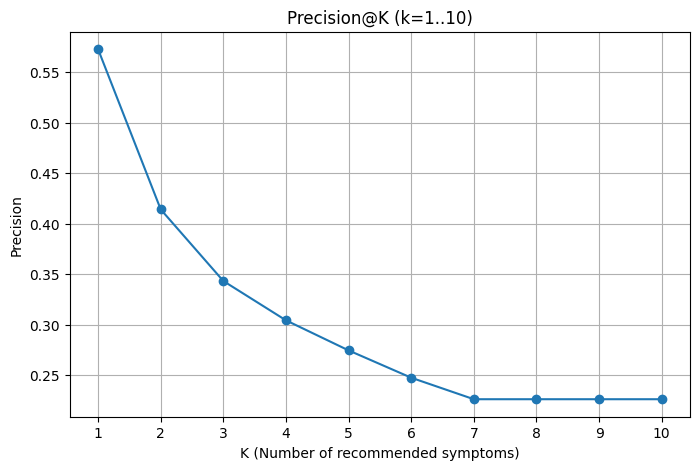

In [ ]:
import matplotlib.pyplot as plt

# --------------------------
# Precision@K for multiple K
# --------------------------
def precision_at_k_curve(df, rules_df, max_k=10):
    results = {}
    for k in range(1, max_k+1):
        results[k] = precision_at_k(df, rules_df, k=k)
    return results

# Run evaluation
precisions = precision_at_k_curve(df, rules, max_k=10)

# --------------------------
# Visualization
# --------------------------
plt.figure(figsize=(8,5))
plt.plot(list(precisions.keys()), list(precisions.values()), marker='o')
plt.title("Precision@K (k=1..10)")
plt.xlabel("K (Number of recommended symptoms)")
plt.ylabel("Precision")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


โมเดล baseline ทำงานได้โอเคใน Top-1 ถึง Top-3

แต่เมื่อ K เพิ่มขึ้น → precision ตกลงอย่างมาก

ถ้าใช้จริง อาจต้องเลือก trade-off:

Precision สูง → แนะนำแค่ 1–3 อาการ

Coverage สูง → ยอม precision ต่ำ แต่ให้ user ได้ list ยาวขึ้น